In [1]:
import sys
sys.path.insert(0, '../classes')

from Model import Model as Model

import pickle


%matplotlib inline
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from importlib import reload

def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')
    
params = {
 'grid.color': '.9',
 'axes.edgecolor': '.5',
 'text.color': '.3',
 'xtick.color': '.5',
 'xtick.direction': 'out',
 'xtick.major.size': 6.0,
 'xtick.minor.size': 3.0,
 'ytick.color': '.5',
 'ytick.direction': 'out',
 'ytick.major.size': 6.0,
 'ytick.minor.size': 3.0    
}
sns.set_style("whitegrid", params)

In [2]:
"""
 FEDFUNDS     : Effective Fed Funds Rate, percent.
 GDP          : Real GDP, 3 decimals, billions of Chained 2000 Dollars.
 INDPRO       : Industrial Production Index
 CPIAUCSL     : Consumer Price Index for All Urban Consumers: All Items
 UNRATE       : Civilian Unemployment Rate
 PAYEMS       : All Employees: Total Nonfarm Payrolls
"""

data = pd.read_csv('quarterly.csv', index_col = 'DATE')
data.head()

,GDPC1,CPIAUCSL,FEDFUNDS,INDPRO,PAYEMS,UNRATE
DATE,,,,,,
1959-01-01,2976.6,29.01,2.48,22.7253,52480.0,6.0
1959-04-01,3049.0,28.98,2.96,24.0048,53320.0,5.2
1959-07-01,3043.1,29.15,3.47,23.8101,53803.0,5.1
1959-10-01,3055.1,29.35,3.98,22.8087,53359.0,5.7
1960-01-01,3123.2,29.37,3.99,25.0061,54274.0,5.2


In [21]:
import scipy.io as sio

factors_data = sio.loadmat('factors.mat')

# process the factors: raw

factors_q = pd.DataFrame(factors_data['quarterly'])

# drop the last period (as done with the data)
factors_q = factors_q[:-1]

# drop every col that has missings after the beginning
factors_q = factors_q.iloc[:, list(factors_q[5:].isnull().sum(axis=0)==0)]


factors_q.head()

,0,1,2,3,4,5,6,7,8,9,...,179,180,181,186,195,197,198,199,200,201
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,5.859993,NaN,NaN,NaN,NaN,NaN
1,0.014227,0.005304,0.022827,0.003951,0.001112,0.062618,0.018332,0.012693,0.013744,0.028256,...,0.003183,0.006014,0.040836,-0.001972,7.463962,-0.041741,-0.013931,-0.002364,0.016019,-0.004836
2,-0.011699,0.000418,0.005026,0.002466,-0.003265,-0.079012,-0.001480,0.015249,0.011848,-0.024915,...,-0.002238,0.000258,0.034865,0.004471,7.134122,-0.001249,0.001657,0.005996,-0.010793,-0.013843
3,-0.005819,-0.008827,-0.062926,0.001149,-0.000902,0.019813,-0.023673,-0.018783,-0.017363,-0.034727,...,-0.002049,0.000497,-0.008452,0.001178,7.536827,0.014089,0.001296,0.007746,0.027083,-0.018261
4,0.012316,-0.000460,0.017535,-0.001931,-0.004577,0.083615,0.020861,0.017329,0.019564,0.024249,...,0.006901,0.010527,-0.037736,0.001021,13.838466,0.026844,0.008344,-0.008004,-0.027850,-0.006025


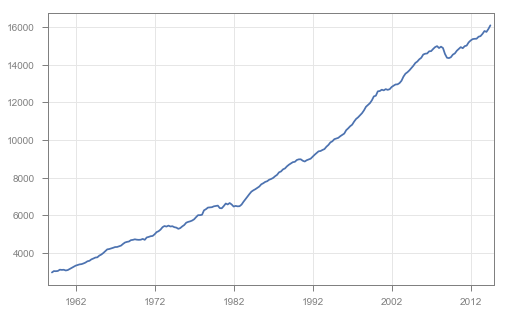

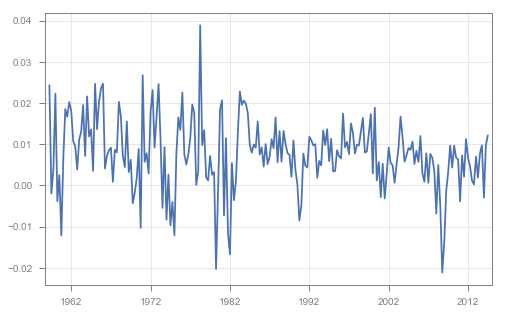

In [623]:
df_raw = data.reset_index(drop = True)
df_raw.columns = ['GDP', 'CPI', 'FF', 'IP', 'emp', 'unemp']

# put the interest variable, GDP, in the format we want to predict: the percentage growth from last period
df = df_raw.copy()
fig, ax = plt.subplots(figsize=(8,5))

dates = pd.to_datetime(data.index, format='%Y-%m-%d')
plt.plot(dates, df['GDP'])
ax.set_xlim([dates[0] - pd.DateOffset(months=6), dates[-1] + pd.DateOffset(months=6)])
plt.savefig('../../latex/plots/GDP_raw.eps', format='eps', dpi=200)

df['GDP'] = df_raw[['GDP']].pct_change()
df = df.iloc[1:]

fig, ax = plt.subplots(figsize=(8,5))

dates = pd.to_datetime(data.index[1:], format='%Y-%m-%d')
plt.plot(dates, df['GDP'])
ax.set_xlim([dates[0] - pd.DateOffset(months=6), dates[-1] + pd.DateOffset(months=6)])
plt.savefig('../../latex/plots/GDP.eps', format='eps', dpi=200)

# descriptive stats

In [598]:
import statsmodels.tsa.stattools as tsa

def f(x):
    return str(x.round(3))

df_raw.describe().loc[['count', 'mean', 'std', 'min', 'max']].to_latex('../../latex/tabs/q_stats_raw.tex', formatters=[f]*df_raw.shape[1])

tmp = df_raw.copy()

tmp['GDP'] = tmp['GDP'].pct_change()
tmp['IP'] = tmp['IP'].apply(np.log).diff(1)
tmp['emp'] = tmp['emp'].apply(np.log).diff(1)
tmp['CPI'] = tmp['CPI'].apply(np.log).diff(2)
tmp['FF'] = tmp['FF'].diff(1)
tmp = tmp.iloc[2:]
tmp2 = tmp.describe().loc[['count', 'mean', 'std', 'min', 'max']]

def g(x):
    _, pvalue, *_ = tsa.adfuller(x)
    return pvalue

tmp2.loc['adfuller'] = tmp.apply(g, axis=0)
tmp2.to_latex('../../latex/tabs/q_stats.tex', formatters=[f]*df_raw.shape[1])

In [ ]:
o = {
    'diffs': {
        'IP': 1,
        'GDP': 0,
        'emp': 1,
        'CPI': 2,
        'FF': 1
    }
}

In [599]:
import statsmodels.tsa.stattools as tsa

_, pvalue, *_ = tsa.adfuller(df['GDP'])
print("p-value: " + str(pvalue))

p-value: 1.64153231343e-10


Reject the unit root hypothesis => stationary

In [28]:
def splitTimeData(df, ratio):
    rows = len(df.index)
    trainRows = int(rows * (1 - ratio))
    testRows = rows - trainRows
    
    train = df.iloc[0:trainRows-1]
    test = df
    start = trainRows
    
    return train, test, start

df_train, df_test, start = splitTimeData(df, 0.18)

In [30]:
'''
standard transformations
'''
from Transform import Transform as Transform

cols = cols = ['IP', 'GDP', 'emp', 'unemp', 'CPI', 'FF']

# not FF, GDP or unemp
t1 = Transform('log', ['IP', 'emp', 'CPI'])

o = {
    'diffs': {
        'IP': 1,
        'GDP': 0,
        'emp': 1,
        'CPI': 2,
        'FF': 1
    }
}


t2 = Transform('diff', cols, o)
t3 = Transform('standardize', cols)
# t3 = Transform('normalize', cols)

transfs =  [t1, t2, t3]

In [31]:
'''
standard scorefuns
'''

def RMSE(y_hat, y):
    start = y_hat.first_valid_index()
    errors = y.loc[start:] - y_hat
    RMSE = np.sqrt(np.mean(np.square(errors)))[0]
    return RMSE

def MAE(y_hat, y):
    start = y_hat.first_valid_index()
    errors = y.loc[start:] - y_hat
    MAE = np.mean(np.absolute(errors))[0]
    return MAE

In [32]:
TEST_OFFSET = df_train.last_valid_index() + 1

In [405]:
try:
    with open("results.p", "rb" ) as f:
        results = pickle.load(f)
except:
    results = {}
results.keys()

# Baseline

In [406]:
from LastPeriod import LastPeriod as LastPeriod

# test
cols = ['GDP']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 1

def gen_x(X, start):
    X = LastPeriod.gen_X(X, start)
    return X

def gen_y(y, start):
    y = LastPeriod.gen_y(y, start)
    return y

model = LastPeriod()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window =  [1, 4, 12]
ret_base = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'direct')
results['BASE'] = ret_base

[ret_base[h][0] for h in window]

step: 190
step: 200
step: 210
step: 220
step: 190
step: 200
step: 210
step: 220
step: 190
step: 200
step: 210
step: 220


[0.0072212569384425499, 0.0093430396086289381, 0.010466315408835523]

# Univariate

## AR

In [407]:
from var_model import VAR as VAR

cols = ['GDP']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 9


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = VAR()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_AR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['AR'] = ret_AR
[ret_AR[h][0] for h in window]

step: 170
step: 175
step: 180
step: 185
step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0066269986735853744, 0.0078888382317660564, 0.0079724063885839198]

## MA

In [408]:
from ARMA import ARMA as ARMA
from var_model import VAR as VAR

# test
cols = ['GDP']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


lags = 1

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
    X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = ARMA(0, 6)


m = Model(model, transfs, gen_x, gen_y, RMSE)

window =  [1, 4, 12]
ret_MA = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic-ar')
results['MA'] = ret_MA
[ret_MA[h][0] for h in window]

step: 170
step: 175
step: 180
step: 185
step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0066287688630359805, 0.0079699114846011592, 0.0080635770161951621]

## ARMA

In [409]:
from ARMA import ARMA as ARMA
from var_model import VAR as VAR

# test
cols = ['GDP']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


lags = 1

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
    X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = ARMA(4, 1)


m = Model(model, transfs, gen_x, gen_y, RMSE)

window =  [1, 4, 12]
ret_ARMA = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic-ar')
results['ARMA'] = ret_ARMA
[ret_ARMA[h][0] for h in window]

step: 170
step: 175
step: 180
step: 185
step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0066478838056817022, 0.0077841448274712762, 0.0080527523401103026]

## MSAR

In [410]:
from MSReg import MSReg

cols = ['GDP']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 5

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MSReg(2)

m = Model(model, transfs, gen_x, gen_y, RMSE)


window = [1, 4, 12]
ret_MSAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic-ar')
results['MSAR'] = ret_MSAR
[ret_MSAR[h][0] for h in window]

step: 170
step: 175
step: 180
step: 185


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:391: RuntimeWarning: invalid value encountered in true_divide
  predicted_joint_probabilities[..., t+1])


step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0067519626531526407, 0.007798057535031609, 0.0080888914235125731]

## SPLITAR

In [519]:
from splitVAR import splitVAR as splitVAR

cols = ['GDP']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 5


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = model = splitVAR(2, proba = True, WLS = True, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols)


m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_splitAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['SPLITAR'] = ret_splitAR
[ret_splitAR[h][0] for h in window]

step: 170
step: 175
step: 180
step: 185
step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0065744570705370256, 0.0080187154322115886, 0.0084770770920459468]

## MLPAR

In [ ]:
from MLP import MLP

cols = ['GDP']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 9


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MLP((4,), training_epochs = 2000, beta=1e-5, debug = False)

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_MLPAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['MLPAR'] = ret_MLPAR
[ret_MLPAR[h][0] for h in window]

In [414]:
# get it from the file
with open("MLPAR.p", "rb" ) as f:
    ret_MLPAR = pickle.load(f)
    results['MLPAR'] = ret_MLPAR
[ret_MLPAR[h][0] for h in window]

[0.0080559940388906948, 0.0079963441088366279, 0.0083869625973054616]

# Multivariate

## VAR

In [415]:
from var_model import VAR as VAR

cols = ['GDP', 'IP']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = VAR()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_VAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['VAR'] = ret_VAR
[ret_VAR[h][0] for h in window]

step: 170
step: 175
step: 180
step: 185
step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0066191446854490634, 0.0076989889875191389, 0.0081060593281606971]

## MSVAR

In [416]:
from var_model import VAR as VAR

cols = ['GDP', 'unemp']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MSReg(2)

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_MSVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic-ar')
results['MSVAR'] = ret_MSVAR
[ret_MSVAR[h][0] for h in window]

step: 170


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 175


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 180
step: 185
step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0068827277143088603, 0.0076688451599557948, 0.0079751893072326184]

## SPLITVAR

In [521]:
from var_model import VAR as VAR

cols = ['GDP', 'unemp']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = splitVAR(2, proba = True, WLS = True, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols)

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_SPLITVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['SPLITVAR'] = ret_SPLITVAR
[ret_SPLITVAR[h][0] for h in window]

step: 170
step: 175
step: 180
step: 185
step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0064774987395959166, 0.0079285242114750434, 0.008499308057805615]

## MLPVAR

In [ ]:
from MLP import MLP

cols = ['GDP', 'CPI']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MLP((4,), training_epochs = 2000, beta=1e-5, debug = True)

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_MLPVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['MLPVAR'] = ret_MLPVAR
[ret_MLPVAR[h][0] for h in window]

In [418]:
# get it from the file
with open("MLPVAR.p", "rb" ) as f:
    ret_MLPVAR = pickle.load(f)
    results['MLPVAR'] = ret_MLPVAR
    
[ret_MLPVAR[h][0] for h in window]

[0.0067597710337673452, 0.0081692706076712772, 0.008659292242025822]

# Factors

## FAVAR

In [460]:
import FAVAR
reload(FAVAR)
FAVAR = 1
from FAVAR import FAVAR

import Model
reload(Model)
Model = 1
from Model import Model


favar = FAVAR(factors_q)
cols = ['GDP']
y_col = ['GDP']


X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]


n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)


lags = 4


def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
    X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = VAR()

m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_FAVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['FAVAR'] = ret_FAVAR
[ret_FAVAR[h][0] for h in window]

step: 170
step: 175
step: 180
step: 185
step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0065468124381959855, 0.0071238348042620718, 0.00763993906063112]

## MSFAVAR

In [461]:
cols = ['GDP']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)

lags = 4

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MSReg(2)
m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_MSFAVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic-ar')
results['MSFAVAR'] = ret_MSFAVAR
[ret_MSFAVAR[h][0] for h in window]

step: 170


/usr/local/lib/python3.6/site-packages/statsmodels/tsa/regime_switching/markov_switching.py:391: RuntimeWarning: invalid value encountered in true_divide
  predicted_joint_probabilities[..., t+1])
/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 175
step: 180
step: 185


/usr/local/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0061895610558222458, 0.0069418823458037814, 0.0076052207784917071]

## SPLITFAVAR

In [506]:
import splitVAR
reload(splitVAR)
splitVAR = 1
from splitVAR import splitVAR

cols = ['GDP']
y_col = ['GDP']

X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)

lags = 4

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = splitVAR(2, proba = True, WLS = True, lags = lags, variables = cols, pred_vars = cols, reg_vars = cols, clustering_type = 'kmeans')
m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_SPLITFAVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['SPLITFAVAR'] = ret_SPLITFAVAR
[ret_SPLITFAVAR[h][0] for h in window]

step: 170
step: 175
step: 180
step: 185
step: 190
step: 195
step: 200
step: 205
step: 210
step: 215
step: 220


[0.0064134080368465048, 0.0067110138877337225, 0.0075996120463741523]

## MLPFAVAR

In [ ]:
favar = FAVAR(factors_q)

cols = ['GDP']
y_col = ['GDP']

# x_cols, y_col = get_cols(cols, 'GDP')
X_train, y_train = df_train[cols], df_train[y_col]
X_test, y_test = df_test[cols], df_test[y_col]

n_factors = 1
X_train = favar.addFactors(X_train, n_factors)
X_test = favar.addFactors(X_test, n_factors)

lags = 4

def gen_x(X, start):
    X = VAR.gen_X(X, lags, start)
#     X = X[:, 1:] # remove constant
    return X

def gen_y(y, start):
    y = VAR.gen_y(y, lags, start)
    return y

model = MLP((4,), training_epochs = 2000, beta=1e-5, debug = True)
m = Model(model, transfs, gen_x, gen_y, RMSE)

window = [1, 4, 12]
ret_MLPFAVAR = m.expanding_window(X_test, y_test, TEST_OFFSET, window, 'dynamic')
results['MLPFAVAR'] = ret_MLPFAVAR
[ret_MLPFAVAR[h][0] for h in window]

In [422]:
# get it from the file
with open("MLPFAVAR.p", "rb" ) as f:
    ret_MLPFAVAR = pickle.load(f)
    results['MLPFAVAR'] = ret_MLPFAVAR
[ret_MLPFAVAR[h][0] for h in window]

[0.0071035152676413174, 0.0084389959510687441, 0.007992247176027931]

# Results

In [522]:
def SE(pred, real):
    return (pred - real)*(pred - real)

def AE(pred, real):
    return abs(pred - real)
    
def DM(results, y, loss, cols = None):
    if cols is None:
        cols = list(results.keys())
    
    ret = {}
    for h in [1, 4, 12]:
        ret[h] = pd.DataFrame(columns=cols[1:], index=cols[0:-1])
        for i in range(len(cols)-1):
            row = {}
            col1 = cols[i]
            for j in range(i+1, len(cols)):
                col2 = cols[j]
                pred1 = results[col1][h][1]
                pred2 = results[col2][h][1]
                row[col2] = DM_comparison(pred2, pred1, y, loss, h)
            ret[h].loc[col1] = pd.Series(row)
            
            
    return ret

def DM_comparison(pred1, pred2, real, loss, h):
    first = pred1.first_valid_index()
    # remove the y values that were used for training
    real = real.loc[first:]
    
    # apply the loss function to every element 
    def f(row):
        return loss(row.iloc[0], row.iloc[1])

    loss1 = pd.concat([pred1, real], axis=1).apply(f, axis=1)
    loss2 = pd.concat([pred2, real], axis=1).apply(f, axis=1)
    d = loss1 - loss2
    d = d.reset_index(drop=True)
#     print(d)
    T = len(d)
    Z = np.mean(d) / np.sqrt(NW(d, h)/T)
#     return NW(d, h)
    return Z

def autocov(d, tau):
    T = len(d)
    mu = np.mean(d)
    return np.mean([(d[i] - mu)*(d[i-tau] - mu) for i in range(tau, T)])
    
def NW(d, h):
    q = h-1
    V = autocov(d, 0) + 2*np.sum([(1 - (nu)/(q+1)) * autocov(d, nu) for nu in range(1, q)])
    return V
    


ret_DM = DM(results, y_test, SE)#, ['FAVAR', 'MSFAVAR', 'ARMA'])

print(ret_DM[1])
print(ret_DM[4])
ret_DM[12]

                  AR         MA      ARMA      MSAR   SPLITAR     MLPAR  \
BASE       -0.697715  -0.653622 -0.606275 -0.523371 -0.773147  0.766984   
AR               NaN  0.0141088   0.13064  0.650041 -0.258183   2.80682   
MA               NaN        NaN  0.180694  0.733282 -0.219287     3.162   
ARMA             NaN        NaN       NaN  0.773034 -0.305856   3.13774   
MSAR             NaN        NaN       NaN       NaN -0.757701   2.68478   
SPLITAR          NaN        NaN       NaN       NaN       NaN   2.79837   
MLPAR            NaN        NaN       NaN       NaN       NaN       NaN   
VAR              NaN        NaN       NaN       NaN       NaN       NaN   
MSVAR            NaN        NaN       NaN       NaN       NaN       NaN   
SPLITVAR         NaN        NaN       NaN       NaN       NaN       NaN   
MLPVAR           NaN        NaN       NaN       NaN       NaN       NaN   
FAVAR            NaN        NaN       NaN       NaN       NaN       NaN   
MSFAVAR          NaN     

,AR,MA,ARMA,MSAR,SPLITAR,MLPAR,VAR,MSVAR,SPLITVAR,MLPVAR,FAVAR,MSFAVAR,SPLITFAVAR,MLPFAVAR
BASE,-1.76988,-1.70429,-1.70923,-1.66688,-1.41846,-1.44552,-1.66482,-1.91422,-1.3711,-1.52198,-3.33469,-3.82378,-3.45469,-2.53213
AR,NaN,3.27926,3.04293,0.378174,3.27422,2.93043,3.18237,0.0169577,3.72521,2.388,-0.411998,-0.378011,-0.419096,0.0316105
MA,NaN,NaN,-2.83633,0.0815792,3.10635,2.77627,2.30904,-0.520811,3.61519,2.14358,-0.519624,-0.468211,-0.516861,-0.112072
ARMA,NaN,NaN,NaN,0.115969,3.20794,2.8358,2.74596,-0.456206,3.63857,2.16065,-0.505791,-0.456644,-0.504393,-0.0949661
MSAR,NaN,NaN,NaN,NaN,1.00465,0.883429,0.0537188,-0.414885,1.17994,1.74577,-0.593789,-0.533371,-0.595691,-0.171471
SPLITAR,NaN,NaN,NaN,NaN,NaN,-1.3024,-2.9252,-2.20231,0.138891,0.594115,-0.98976,-0.866494,-0.950211,-0.718221
MLPAR,NaN,NaN,NaN,NaN,NaN,NaN,-2.56756,-1.82847,0.944797,0.945875,-0.870098,-0.767279,-0.841439,-0.584758
VAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.701909,3.73085,1.94411,-0.561292,-0.504037,-0.55471,-0.1745
MSVAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.97513,3.26644,-0.511512,-0.451046,-0.511119,0.0355731
SPLITVAR,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.540679,-0.968823,-0.855867,-0.926376,-0.710389


In [524]:
pickle.dump(results, open( "results.p", "wb" ) )

In [523]:
import io
import math


def process_val(val):
    if math.isnan(val):
        return '-'
    else:
        if abs(val) > 1.96:
            return '\\textbf{ ' + '{:.2f}'.format(round(val, 2)) + '}'
        else:
            return '{:.2f}'.format(round(val, 2))

                                   
def convertToLaTeX(df, alignment="c", title=''):
    """
    Convert a pandas dataframe to a LaTeX tabular.
    Prints labels in bold, does not use math mode
    """
    numColumns = df.shape[1]
    numRows = df.shape[0]
    output = io.StringIO()
    colFormat = ("%s|%s" % ('r', alignment * numColumns))
    #Write header
    output.write("\\begin{tabular}{%s}\n" % colFormat)
    columnLabels = ["\\rot{ \\textbf{%s} }" % label for label in df.columns]
    output.write("%s& %s\\\\\\hline\n" % (title, " & ".join(columnLabels)))
    #Write data lines
    for i in range(numRows):
        output.write("\\textbf{%s} & %s\\\\\n"
                     % (df.index[i], " & ".join([process_val(val) for val in df.iloc[i]])))
    #Write footer
    output.write("\\end{tabular}")
    return output.getvalue()

out = 'GDP'
for h in [1, 4, 12]:
    with open('../../latex/tabs/DM_' + out + '_' + str(h) + '.tex', "w" ) as f:
        f.write(convertToLaTeX(ret_DM[h], title=out + ': ' + str(h) + ' ahead'))

In [525]:
def cost_comparison(results, y, losses, losses_names, models=None):
    if models is None:
        models = list(results.keys())
        
    hs = results[models[0]].keys()

    tuples = [(loss, h) for loss in losses_names for h in hs]
    index = pd.MultiIndex.from_tuples(tuples, names=['Loss', 'Periods ahead'])
    ret = pd.DataFrame(columns = index)
#     ret.loc['base'] = pd.Series(np.random.randn(6), index=index)
    for model in models:
        s = pd.Series(index=index)
        for loss_idx in range(len(losses)):
            for h in hs:
                loss = losses[loss_idx]
                s.loc[(losses_names[loss_idx], h)] = loss(results[model][h][1], y)                
        ret.loc[model] = s
        
    
    return ret
    

def scale_losses(ret_losses):
    losses = list(ret_losses.columns.get_level_values(0).unique())
    hs = list(ret_losses.columns.get_level_values(1).unique())
    
    for loss in losses:
        ref = ret_losses[loss][hs[0]].iloc[0]
        ret_losses[loss] = ret_losses[loss] / ref
    
    return ret_losses
    
def is_col_min(df):
    return df == df.min()
    
ret_losses_r = cost_comparison(results, y_test, [RMSE, MAE], ['RMSE', 'MAE'])

# scale the results so that the 1 period loss is always 1

ret_losses = scale_losses(ret_losses_r.copy())

ret_losses_is_min = is_col_min(ret_losses)

pickle.dump(ret_losses, open( "../agg/GDP.p", "wb" ) )

ret_losses

Loss               RMSE                           MAE                    
Periods ahead        1         4         12        1         4         12
BASE           1.000000  1.293825  1.449376  1.000000  1.152143  1.170600
AR             0.917707  1.092447  1.104019  0.815382  0.899611  0.875509
MA             0.917952  1.103674  1.116645  0.797736  0.870454  0.884026
ARMA           0.920599  1.077949  1.115146  0.773875  0.852419  0.881914
MSAR           0.935012  1.079875  1.120150  0.800572  0.935796  0.917644
SPLITAR        0.910431  1.110432  1.173906  0.790050  0.924567  0.936708
MLPAR          1.115594  1.107334  1.161427  1.017494  0.979177  0.907812
VAR            0.916619  1.066156  1.122527  0.791730  0.843280  0.890614
MSVAR          0.953120  1.061982  1.104405  0.819054  0.923986  0.879136
SPLITVAR       0.897004  1.097942  1.176985  0.827602  0.976080  0.943779
MLPVAR         0.936093  1.131281  1.199139  0.799059  0.931050  0.981400
FAVAR          0.906603  0.986509  1.057979  0.861604  0.861148  0.879817
MSFAVAR        0.857131  0.961312  1.053171  0.842083  0.836400  0.892936
SPLITFAVAR     0.888129  0.929342  1.052395  0.842817  0.828791  0.898903
MLPFAVAR       0.983695  1.168633  1.106767  0.914933  1.089134  0.947811

In [526]:
from itertools import groupby

def process_val(val, i, j):
    if ret_losses_is_min.iloc[i, j]: # is col min
        return '{\\color{red} \\textbf{' + str(round(val, 2)) + '}}'
    else:
        return str(round(val, 2))

def convertToLaTeX(df, alignment="c"):
    """
    Convert a pandas dataframe to a LaTeX tabular.
    Prints labels in bold, does not use math mode
    """
    first = list(df.columns.get_level_values(0))
    first_group = [(key, len(list(group))) for key, group in groupby(first)]
    second = list(df.columns.get_level_values(1))
    
    numColumns = df.shape[1]
    numRows = df.shape[0]
    output = io.StringIO()
    cols_align = "|".join(["%s" % (alignment * l) for key, l in first_group])
    colFormat = ("%s|%s" % ('l', cols_align))
    #Write header
    output.write("\\begin{tabular}{%s}\n" % colFormat)
    output.write('\\toprule\n')
        
    # top cols    
    columnLabels = ["\multicolumn{%i}{c}{%s}" % (l, label) for label, l in first_group]
    output.write("%s & %s\\\\\n" % (df.columns.names[0]," & ".join(columnLabels)))
    
    # second col
    columnLabels = ["%s" % label for label in second]
    output.write("%s & %s\\\\\\hline\n" % (df.columns.names[1]," & ".join(columnLabels)))

#     columnLabels = ["\\rot{ \\textbf{%s} }" % label for label in df.columns]
#     output.write("& %s\\\\\\hline\n" % " & ".join(columnLabels))
    #Write data lines
    for i in range(numRows):
        output.write("%s & %s\\\\\n"
                     % (df.index[i], " & ".join([process_val(df.iloc[i, j], i, j) for j in range(numColumns)])))
    #Write footer
    output.write("\\end{tabular}")
    return output.getvalue()

with open('../../latex/tabs/GDP_losses.tex', "w" ) as f:
    f.write(convertToLaTeX(ret_losses))

In [321]:
# ret_losses.to_latex('../../latex/tabs/test3.tex')
ret_losses.columns.names[0]

'loss'

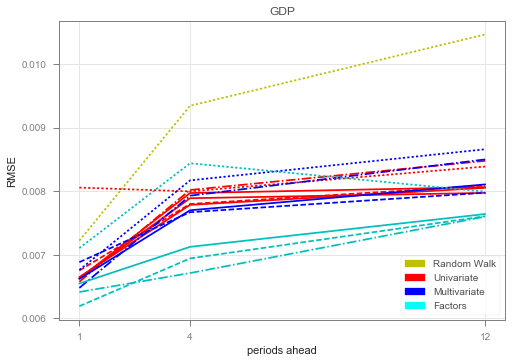

In [624]:
import matplotlib.patches as mpatches


df = ret_losses_r['RMSE'].transpose()

plt.plot(df['BASE'], color='y', linestyle = ':')
plt.plot(df['AR'], color='r')
plt.plot(df['MA'], color='r')
plt.plot(df['ARMA'], color='r', linestyle = '-')
plt.plot(df['MSAR'], color='r', linestyle = '--')
plt.plot(df['SPLITAR'], color='r', linestyle = '-.')
plt.plot(df['MLPAR'], color='r', linestyle = ':')
plt.plot(df['VAR'], color='b', linestyle = '-')
plt.plot(df['MSVAR'], color='b', linestyle = '--')
plt.plot(df['SPLITVAR'], color='b', linestyle = '-.')
plt.plot(df['MLPVAR'], color='b', linestyle = ':')
plt.plot(df['FAVAR'], color='c', linestyle = '-')
plt.plot(df['MSFAVAR'], color='c', linestyle = '--')
plt.plot(df['SPLITFAVAR'], color='c', linestyle = '-.')
plt.plot(df['MLPFAVAR'], color='c', linestyle = ':')

plt.xticks([1, 4, 12])
plt.xlabel('periods ahead')
plt.ylabel('RMSE')

RW = mpatches.Patch(color='y', label='Random Walk')
uni = mpatches.Patch(color='red', label='Univariate')
multi = mpatches.Patch(color='blue', label='Multivariate')
factors = mpatches.Patch(color='cyan', label='Factors')



plt.legend(handles=[RW, uni, multi, factors], loc='lower right', frameon=True)

plt.title('GDP')
plt.savefig('../../latex/plots/GDP_all.eps', format='eps', dpi=200)

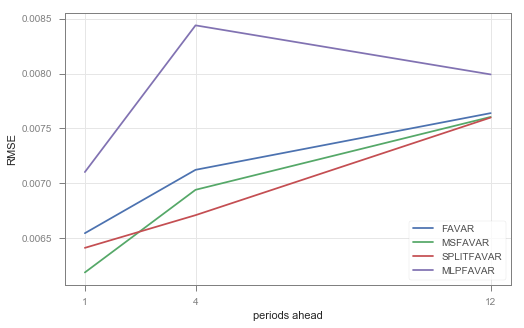

In [529]:
fig, ax = plt.subplots(figsize=(8,5))


plt.plot(df['FAVAR'], label='FAVAR')
plt.plot(df['MSFAVAR'], label='MSFAVAR')
plt.plot(df['SPLITFAVAR'], label='SPLITFAVAR')
plt.plot(df['MLPFAVAR'], label='MLPFAVAR')

plt.xticks([1, 4, 12])
plt.xlabel('periods ahead')
plt.ylabel('RMSE')

legend = ax.legend(loc='lower right', frameon=True)

plt.savefig('../../latex/plots/GDP_favar.eps', format='eps', dpi=200)